In [1]:
import cv2
import numpy as np
# import pandas as pd
import os
import mysql.connector
import matplotlib.pyplot as plt
# import matplotlib.patches as patches

In [2]:
# Connect to MySQL
database = mysql.connector.connect(
    user='root', password='jarvis@admin', host='192.168.1.97', port='3306')
cursor = database.cursor()


In [ ]:
# Using dnn for face detection from directory and save into csv file
modelFile = "../dnn/res10_300x300_ssd_iter_140000.caffemodel"
configFile = "../dnn/deploy.prototxt.txt"
net = cv2.dnn.readNetFromCaffe(configFile, modelFile)


def extract_frontal_face_cord(image_ndarray):
    height, width, _ = image_ndarray.shape
    # image_ndarray = cv2.resize(image_ndarray,(height,width))
    blob = cv2.dnn.blobFromImage(
        image_ndarray, 1.0, (height, width), (104.0, 177.0, 123.0))
    net.setInput(blob)
    detections = net.forward()

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5:
            box = detections[0, 0, i, 3:7] * \
                np.array([width, height, width, height])
            (x, y, x2, y2) = box.astype("int")
            return x, y, x2, y2
        else:
            return 0, 0, 0, 0

In [ ]:
# df = pd.DataFrame(columns=['PATH', 'X', 'Y', 'W', 'H'])

def return_face_cordinates(path):
    image = cv2.imread(path)
    X, Y, W, H = extract_frontal_face_cord(image)
    return X, Y, W, H
    # df.loc[len(df)] = [X, Y, W, H]


In [ ]:
def list_images_in_directory(path):
    files_list = []
    for root, _, files in os.walk(path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                files_list.append(os.path.join(root, file))
    # image_files.sort()
    # files.sort()
    return files_list


In [ ]:
# create database
# cursor.execute("DROP DATABASE IF EXISTS POSITIVE_DATASETS")
cursor.execute("CREATE DATABASE IF NOT EXISTS POSITIVE_DATASET;")
cursor.execute("USE POSITIVE_DATASET;")

# create table
cursor.execute("DROP TABLE IF EXISTS POSITIVE_FACE_DATASET;")
cursor.execute("CREATE TABLE POSITIVE_FACE_DATASET (PATH VARCHAR(100) PRIMARY KEY, X INT, Y INT, W INT, H INT);")

database.commit()

In [ ]:
cursor.execute("SHOW DATABASES;")
cursor.fetchall()

In [ ]:
pos_data_dir = '/coding-drive/DATASETS/positive_face_dataset/'

for file_path in list_images_in_directory(pos_data_dir):
    X, Y, W, H = return_face_cordinates(file_path)
    cursor.execute("INSERT INTO POSITIVE_FACE_DATASET VALUES (%s, %s, %s, %s, %s)",
                   (file_path, X.item(), Y.item(), W.item(), H.item()))
    
database.commit()

path: /coding-drive/DATASETS/positive_face_dataset/Swarnim/Swarnim_1.jpg  X: 200  Y: 61  W: 322  H: 228


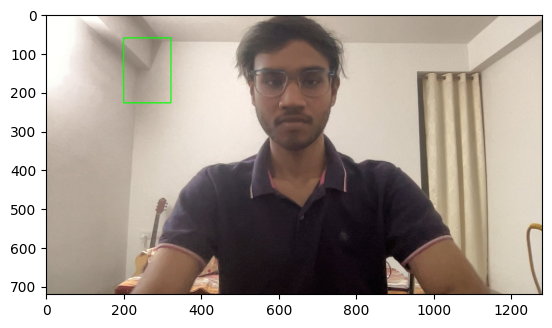

path: /coding-drive/DATASETS/positive_face_dataset/Swarnim/Swarnim_10.jpg  X: 260  Y: 67  W: 361  H: 226


[ WARN:0@66.715] global loadsave.cpp:244 findDecoder imread_('/coding-drive/DATASETS/positive_face_dataset/Swarnim/Swarnim_10.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [4]:
def image_visualizer(path, X, Y, W, H):
    # plot image
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.rectangle(image, (X, Y), (W, H), (0, 255, 0), 2)
    plt.imshow(image)
    plt.show()
    

cursor.execute("USE POSITIVE_DATASET;")
cursor.execute(
    "SELECT * FROM POSITIVE_FACE_DATASET WHERE PATH LIKE '%Swarnim%';")
results = cursor.fetchall()
for result in results:
    path, X, Y, W, H = result[0], result[1], result[2], result[3], result[4]
    print('path:', path, ' X:', X, ' Y:', Y, ' W:', W, ' H:', H)
    image_visualizer(path, X, Y, W, H)


In [ ]:
# closing the connection
cursor.close()
database.close()
